In [2]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

In [3]:
MAX_INT = 1000000000

In [4]:
valid_guesses = pd.read_csv('data/valid_guesses.csv')
valid_solutions = pd.read_csv('data/valid_solutions.csv')
candidate_guesses = valid_guesses.append(valid_solutions, ignore_index=True).sort_values('word')
if not os.path.exists('data/candidate_guesses.csv'):
    candidate_guesses.to_csv('data/candidate_guesses.csv', index=False)

/tmp/ipykernel_3830/4142468350.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  candidate_guesses = valid_guesses.append(valid_solutions, ignore_index=True).sort_values('word')


In [5]:
valid_guesses

,word
0,aahed
1,aalii
2,aargh
3,aarti
4,abaca
...,...
10652,zuzim
10653,zygal
10654,zygon
10655,zymes


In [6]:
valid_solutions

,word
0,aback
1,abase
2,abate
3,abbey
4,abbot
...,...
2310,young
2311,youth
2312,zebra
2313,zesty


In [7]:
candidate_guesses

,word
0,aahed
1,aalii
2,aargh
3,aarti
4,abaca
...,...
10652,zuzim
10653,zygal
10654,zygon
10655,zymes


In [8]:
print(valid_guesses.dtypes, valid_solutions.dtypes)

word    object
dtype: object word    object
dtype: object


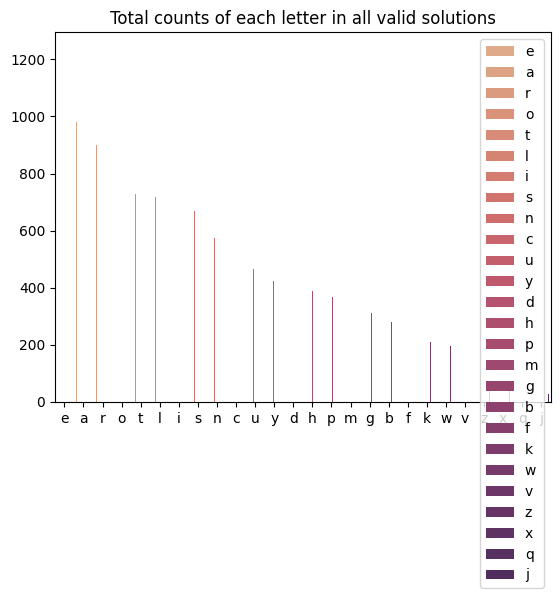

In [9]:
# Graph the total counts of each letter in all valid solutions
letter_counts = pd.Series(dtype=object)
for letter in 'abcdefghijklmnopqrstuvwxyz':
    letter_counts[letter] = valid_solutions['word'].str.count(letter).sum()
letter_counts = letter_counts.sort_values(ascending=False)
sns.barplot(x=letter_counts.index, y=letter_counts.values, palette='flare', hue=letter_counts.index)
plt.title('Total counts of each letter in all valid solutions')
plt.show()

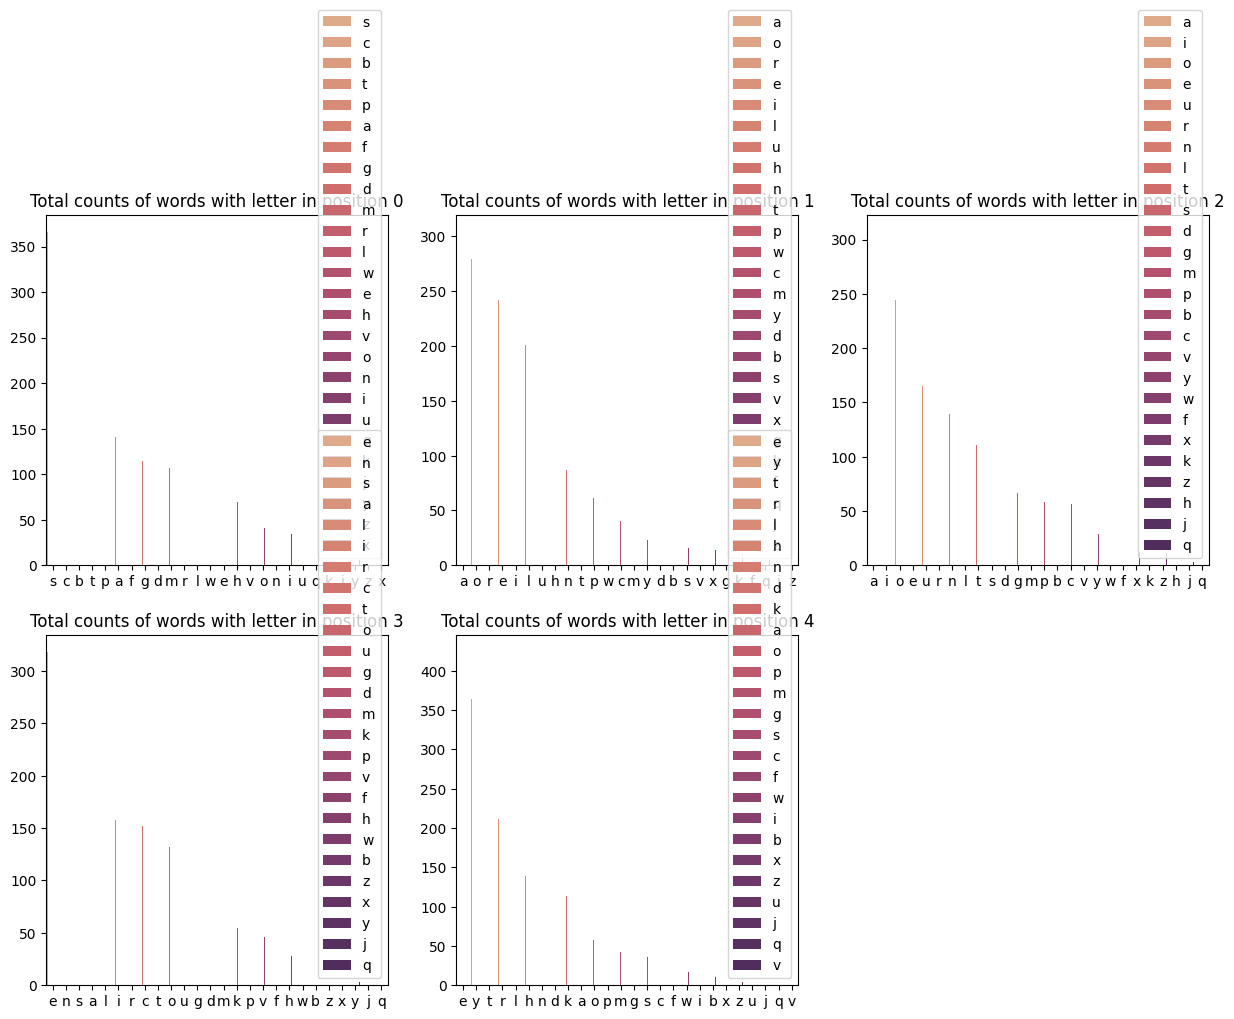

In [10]:
plt.figure(figsize=(15, 10))
for i in range(5):
    plt.subplot(2, 3, i + 1)
    letter_counts_by_position = pd.Series(dtype=object)
    for letter in 'abcdefghijklmnopqrstuvwxyz':
        letter_counts_by_position[letter] = valid_solutions[valid_solutions['word'].str[i] == letter].shape[0]
    letter_counts_by_position = letter_counts_by_position.sort_values(ascending=False)
    sns.barplot(x=letter_counts_by_position.index, y=letter_counts_by_position.values, palette='flare', hue=letter_counts_by_position.index)
    plt.title(f'Total counts of words with letter in position {i}')
plt.show()

In [11]:
def wordle_guess(guess, solution):
    '''
    guess: a string of 5 letters
    solution: a string of 5 letters
    return: a list of 5 integers where
     - 0 means the letter is not in the solution
     - 1 means the letter is in the solution but in the wrong position
     - 2 means the letter is in the solution and in the right position
    '''
    if len(guess) != len(solution):
        print(len(guess), len(solution))
        return -1

    result = [0] * len(guess)
    letter_occurrences = Counter(solution)
    for i in range(len(guess)):
        if guess[i] == solution[i]:
            result[i] = 2
            letter_occurrences[guess[i]] -= 1
    for i in range(len(guess)):
        if result[i] != 2 and letter_occurrences[guess[i]] > 0:
            result[i] = 1
            letter_occurrences[guess[i]] -= 1
    return "".join(map(str, result))

In [12]:
print(wordle_guess('sooey', 'eeeie'), wordle_guess('trace', 'amaze'))

00010 00202


In [13]:
# Almost-a-Trinary generator
def wordle_response_generator(n):
    '''
    n: an integer
    return: a list of n trinary numbers
    '''
    if n == 0:
        return ''
    if n == 1:
        return '012'
    result = []
    for trinary in wordle_response_generator(n - 1):
        for i in range(3):
            if sum([int(x) for x in trinary]) + i != 9:
                result.append(trinary + str(i))
    return result

In [14]:
# IDEA: use largest_bucket to prune the search
# candidate_guess = candidate_guesses['word'][0]
# response_buckets = {}
# bucket_counter = Counter()
# largest_bucket = 0
# for solution in valid_solutions['word']:
#     response = wordle_guess(candidate_guess, solution)
#     response_buckets[response] = pd.concat([response_buckets[response], pd.DataFrame(columns=['word'], data=[solution])])
#     bucket_counter[response] += 1
#     if bucket_counter[response] > largest_bucket:
#         largest_bucket = bucket_counter[response]

In [15]:
def wordle_response_bucket_distributions(valid_solutions):
    '''
    candidate_guesses: a DataFrame of candidate guesses
    valid_solutions: a DataFrame of valid solutions
    return: a dictionary of candidate guesses with their respective bucket distributions
    '''
    candidate_guesses_bucket_lengths = {}
    for candidate_guess in candidate_guesses['word']:
        print(candidate_guess, end='\r')
        bucket_counter = Counter()
        for solution in valid_solutions['word']:
            response = wordle_guess(candidate_guess, solution)
            bucket_counter[response] += 1
        candidate_guesses_bucket_lengths[candidate_guess] = bucket_counter
    return candidate_guesses_bucket_lengths

In [16]:
# Completely exhaustive search, storing every candidate's bucket distribution
candidate_guesses_bucket_lengths = {}
# Turns 2min into >2hr
# candidate_guesses_response_buckets = {}
for candidate_guess in candidate_guesses['word']:
    print(candidate_guess[0], end='\r')
    bucket_counter = Counter()
    for solution in valid_solutions['word']:
        response = wordle_guess(candidate_guess, solution)
        # response_buckets[response].loc[len(response_buckets[response])] = [solution]
        bucket_counter[response] += 1
    # candidate_guesses_response_buckets[candidate_guess] = response_buckets
    candidate_guesses_bucket_lengths[candidate_guess] = bucket_counter

In [17]:
# Save candidates_guesses_bucket_lengths to a file
with open('candidates_guesses_bucket_lengths.txt', 'w') as f:
    for candidate_guess in candidate_guesses_bucket_lengths:
        f.write(f'{candidate_guess}: {candidate_guesses_bucket_lengths[candidate_guess]}\n')

In [18]:
# Find the smallest largest bucket
smallest_largest_bucket = MAX_INT
best_candidate = ''
for candidate_guess in candidate_guesses_bucket_lengths:
    largest_bucket = candidate_guesses_bucket_lengths[candidate_guess].most_common(1)[0][1]
    print(candidate_guess, largest_bucket)
    if smallest_largest_bucket > largest_bucket:
        smallest_largest_bucket = largest_bucket
        best_candidate = candidate_guess

aahed 448
aalii 668
aargh 587
aarti 380
abaca 993
abaci 624
aback 925
abacs 668
abaft 774
abaka 1136
abamp 898
aband 753
abase 423
abash 702
abask 807
abate 419
abaya 1001
abbas 872
abbed 523
abbes 423
abbey 442
abbot 543
abcee 481
abeam 535
abear 431
abele 457
abers 278
abets 295
abhor 378
abide 299
abies 234
abled 380
abler 291
ables 297
ablet 278
ablow 518
abmho 549
abode 293
abohm 549
aboil 344
aboma 684
aboon 583
abord 412
abore 252
abort 335
about 369
above 327
abram 674
abray 598
abrim 388
abrin 331
abris 287
absey 288
absit 397
abuna 682
abune 296
abuse 275
abuts 462
abuzz 908
abyes 288
abysm 594
abyss 683
acais 493
acari 426
accas 793
accoy 541
acerb 326
acers 237
aceta 359
achar 580
ached 351
aches 298
achoo 600
acids 379
acidy 455
acing 478
acini 560
ackee 506
acker 341
acmes 305
acmic 624
acned 329
acnes 257
acock 654
acold 400
acorn 315
acred 307
acres 237
acrid 343
acros 284
acted 277
actin 378
acton 350
actor 294
acute 231
acyls 427
adage 505
adapt 633
adaws 722
adays 63

In [19]:
# Find the n smallest largest buckets
def find_n_smallest_largest_buckets(n, candidate_guesses_bucket_lengths):
    smallest_largest_buckets = [MAX_INT] * n
    best_candidates = [''] * n
    for candidate_guess in candidate_guesses_bucket_lengths:
        largest_bucket = candidate_guesses_bucket_lengths[candidate_guess].most_common(1)[0][1]
        for i in range(n):
            if smallest_largest_buckets[i] > largest_bucket:
                smallest_largest_buckets[i] = largest_bucket
                best_candidates[i] = candidate_guess
                break
    return smallest_largest_buckets, best_candidates

In [20]:
smallest_largest_buckets, best_candidates = find_n_smallest_largest_buckets(10, candidate_guesses_bucket_lengths)
print(smallest_largest_buckets, best_candidates)

[168, 168, 168, 168, 168, 177, 183, 186, 186, 187] ['aesir', 'arise', 'raise', 'reais', 'serai', 'stoae', 'soare', 'oriel', 'reoil', 'uraei']


In [21]:
def plot_bucket_distribution(candidate_guess, candidate_guesses_bucket_lengths):
    bucket_distribution = candidate_guesses_bucket_lengths[candidate_guess]
    bucket_distribution = pd.Series(bucket_distribution).sort_values(ascending=False)
    sns.barplot(x=bucket_distribution.index, y=bucket_distribution.values, palette='flare', hue=bucket_distribution.index)
    plt.xticks(rotation=90)
    plt.tick_params(axis='x', which='major', labelsize=12)
    plt.xlabel('Wordle Response')
    plt.ylabel('Count of Candidates')
    plt.title(f'Bucket distribution for candidate guess {candidate_guess}')

In [22]:
def plot_bucket_distributions(candidate_guesses, candidate_guesses_bucket_lengths):
    plt.subplots(5, 2, figsize=(50, 40))
    for i, candidate_guess in enumerate(candidate_guesses):
        plt.subplot(5, 2, i + 1)
        plot_bucket_distribution(candidate_guess, candidate_guesses_bucket_lengths)
    plt.show()

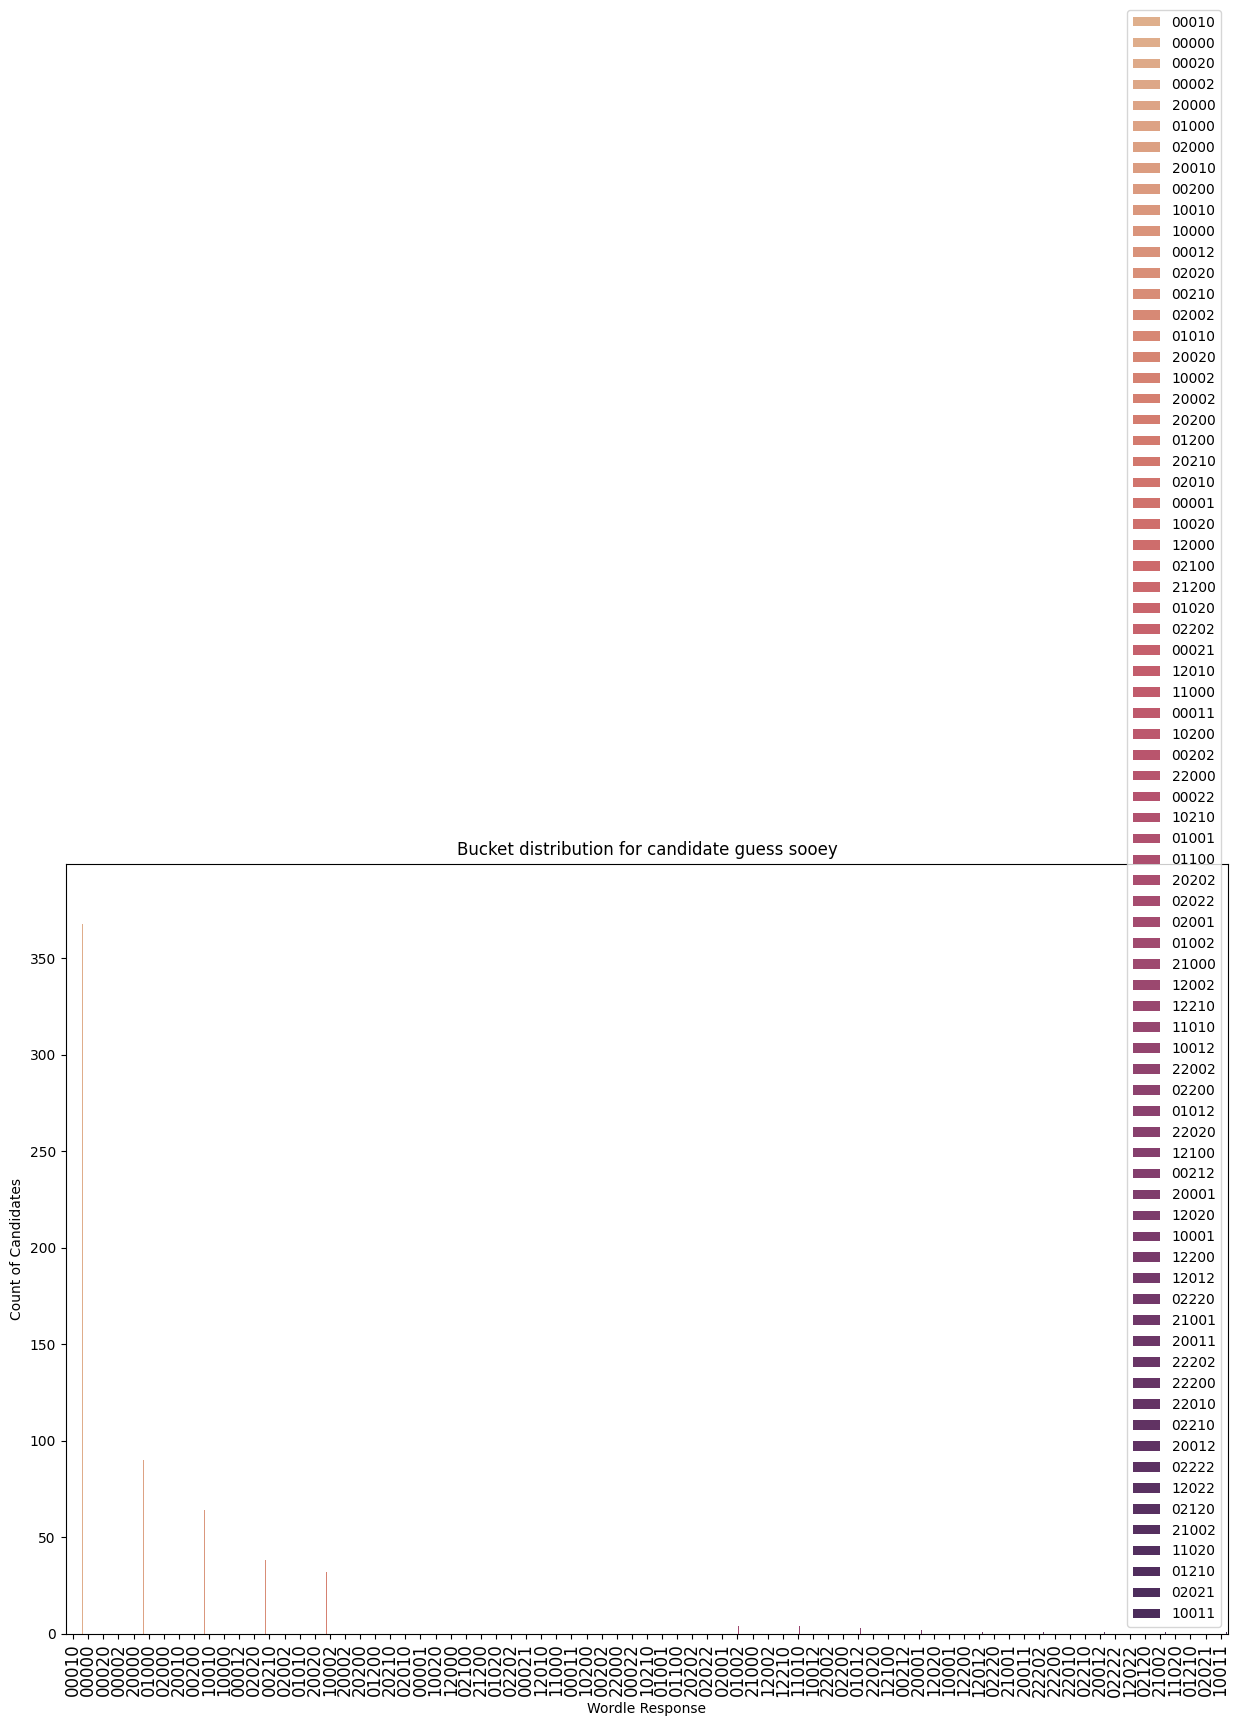

In [23]:
plt.figure(figsize=(15, 10))
plot_bucket_distribution('sooey', candidate_guesses_bucket_lengths)

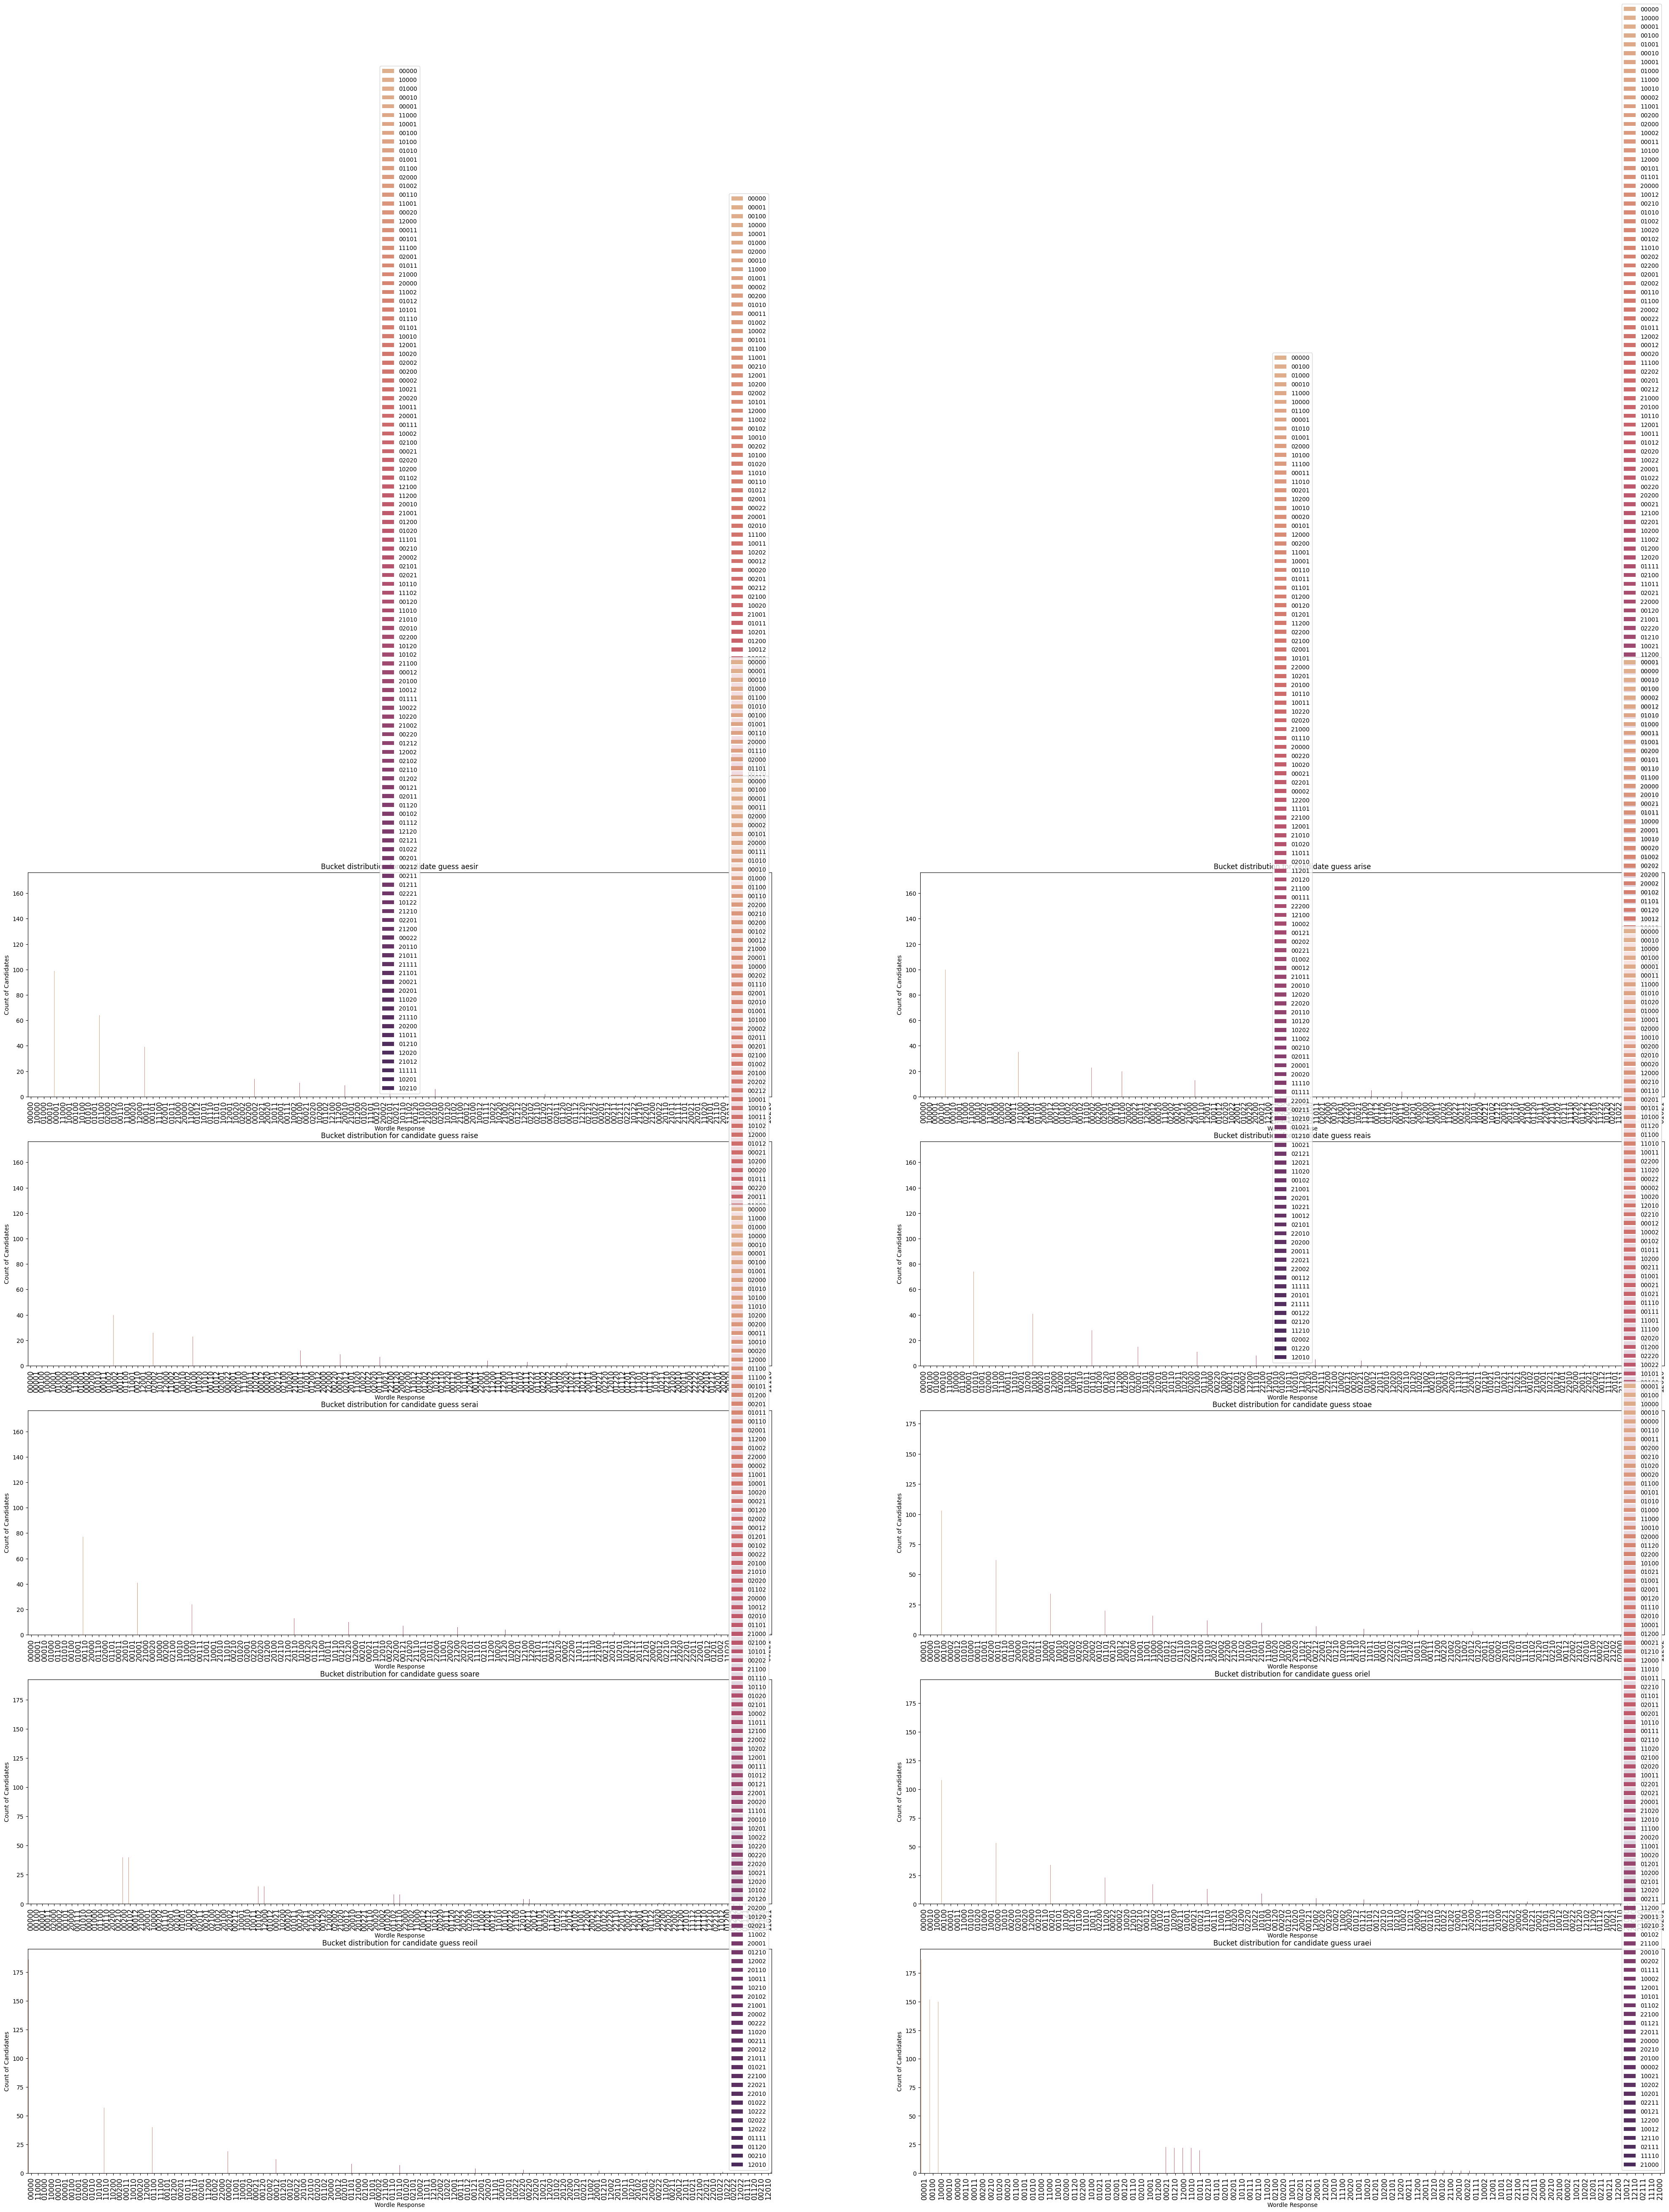

In [24]:
plot_bucket_distributions(best_candidates, candidate_guesses_bucket_lengths)
# judging from this, 'raise' has the smallest largest bucket and the smallest 2nd largest bucket

In [25]:
response_buckets = {}
for response in wordle_response_generator(5):
    response_buckets[response] = pd.DataFrame(columns=['word'])

In [26]:
def make_response_buckets(best_candidate, valid_solutions, response_buckets):
    print(best_candidate, end='\r')
    response_buckets = {}
    for solution in valid_solutions['word']:
        response = wordle_guess(best_candidate, solution)
        if response not in response_buckets:
            response_buckets[response] = pd.DataFrame(columns=['word'])
        response_buckets[response].loc[len(response_buckets[response])] = [solution]
    return response_buckets

In [27]:
candidate_guesses_response_buckets = {}
for candidate_guess in best_candidates:
    print(candidate_guess, end='\r')
    candidate_guesses_response_buckets[candidate_guess] = {}
    for solution in valid_solutions['word']:
        response = wordle_guess(candidate_guess, solution)
        if response not in candidate_guesses_response_buckets[candidate_guess]:
            candidate_guesses_response_buckets[candidate_guess][response] = pd.DataFrame(columns=['word'])
        candidate_guesses_response_buckets[candidate_guess][response].loc[len(candidate_guesses_response_buckets[candidate_guess][response])] = [solution]
# Approx 22s for 10 words -> 8hrs for 12972 words

In [33]:
candidate_guesses_response_buckets['raise']['10200']

,word
0,brick
1,bring
2,brink
3,briny
4,chirp
5,crick
6,crimp
7,drift
8,drill
9,drink


In [34]:
valid_solutions = candidate_guesses_response_buckets['raise']['10200']

In [35]:
l2_response_bucket_distribution = wordle_response_bucket_distributions(valid_solutions)
l2_sl_bucket_sizes, l2_best_candidates = find_n_smallest_largest_buckets(10, l2_response_bucket_distribution)

In [36]:
l2_sl_bucket_sizes, l2_best_candidates

([5, 5, 5, 5, 5, 6, 6, 6, 6, 6],
 ['clonk',
  'plank',
  'plink',
  'plonk',
  'plunk',
  'kelpy',
  'klong',
  'knelt',
  'lynch',
  'octyl'])

In [32]:
plot_bucket_distributions(l2_best_candidates, l2_response_bucket_distribution)

KeyboardInterrupt: 

In [38]:
for word in ['clonk', 'plank', 'plink', 'plonk', 'plunk']:
    print(l2_response_bucket_distribution[word])

Counter({'00020': 5, '00000': 5, '01000': 5, '10002': 3, '00022': 2, '20000': 2, '00100': 2, '20002': 1, '02000': 1, '01001': 1, '00002': 1})
Counter({'01000': 5, '00002': 4, '00020': 4, '00000': 4, '20000': 3, '00022': 2, '10000': 2, '02000': 1, '01001': 1, '20002': 1, '20020': 1})
Counter({'01200': 5, '00202': 4, '00220': 4, '00200': 4, '20200': 3, '00222': 2, '10200': 2, '02200': 1, '01201': 1, '20202': 1, '20220': 1})
Counter({'01000': 5, '00002': 4, '00020': 4, '00000': 4, '00022': 2, '10000': 2, '20100': 2, '02000': 1, '01001': 1, '20002': 1, '20020': 1, '20000': 1})
Counter({'01000': 5, '00020': 4, '00000': 4, '00002': 3, '20000': 3, '00022': 2, '10000': 2, '02000': 1, '01001': 1, '20002': 1, '20020': 1, '00102': 1})


In [39]:
l2_response_buckets = make_response_buckets('plunk', valid_solutions, response_buckets)

In [45]:
valid_solutions = l2_response_buckets['20000']
l3_response_bucket_distribution = wordle_response_bucket_distributions(valid_solutions)
l3_sl_bucket_sizes, l3_best_candidates = find_n_smallest_largest_buckets(10, l3_response_bucket_distribution)

In [46]:
valid_solutions

,word
0,primo
1,prior
2,privy


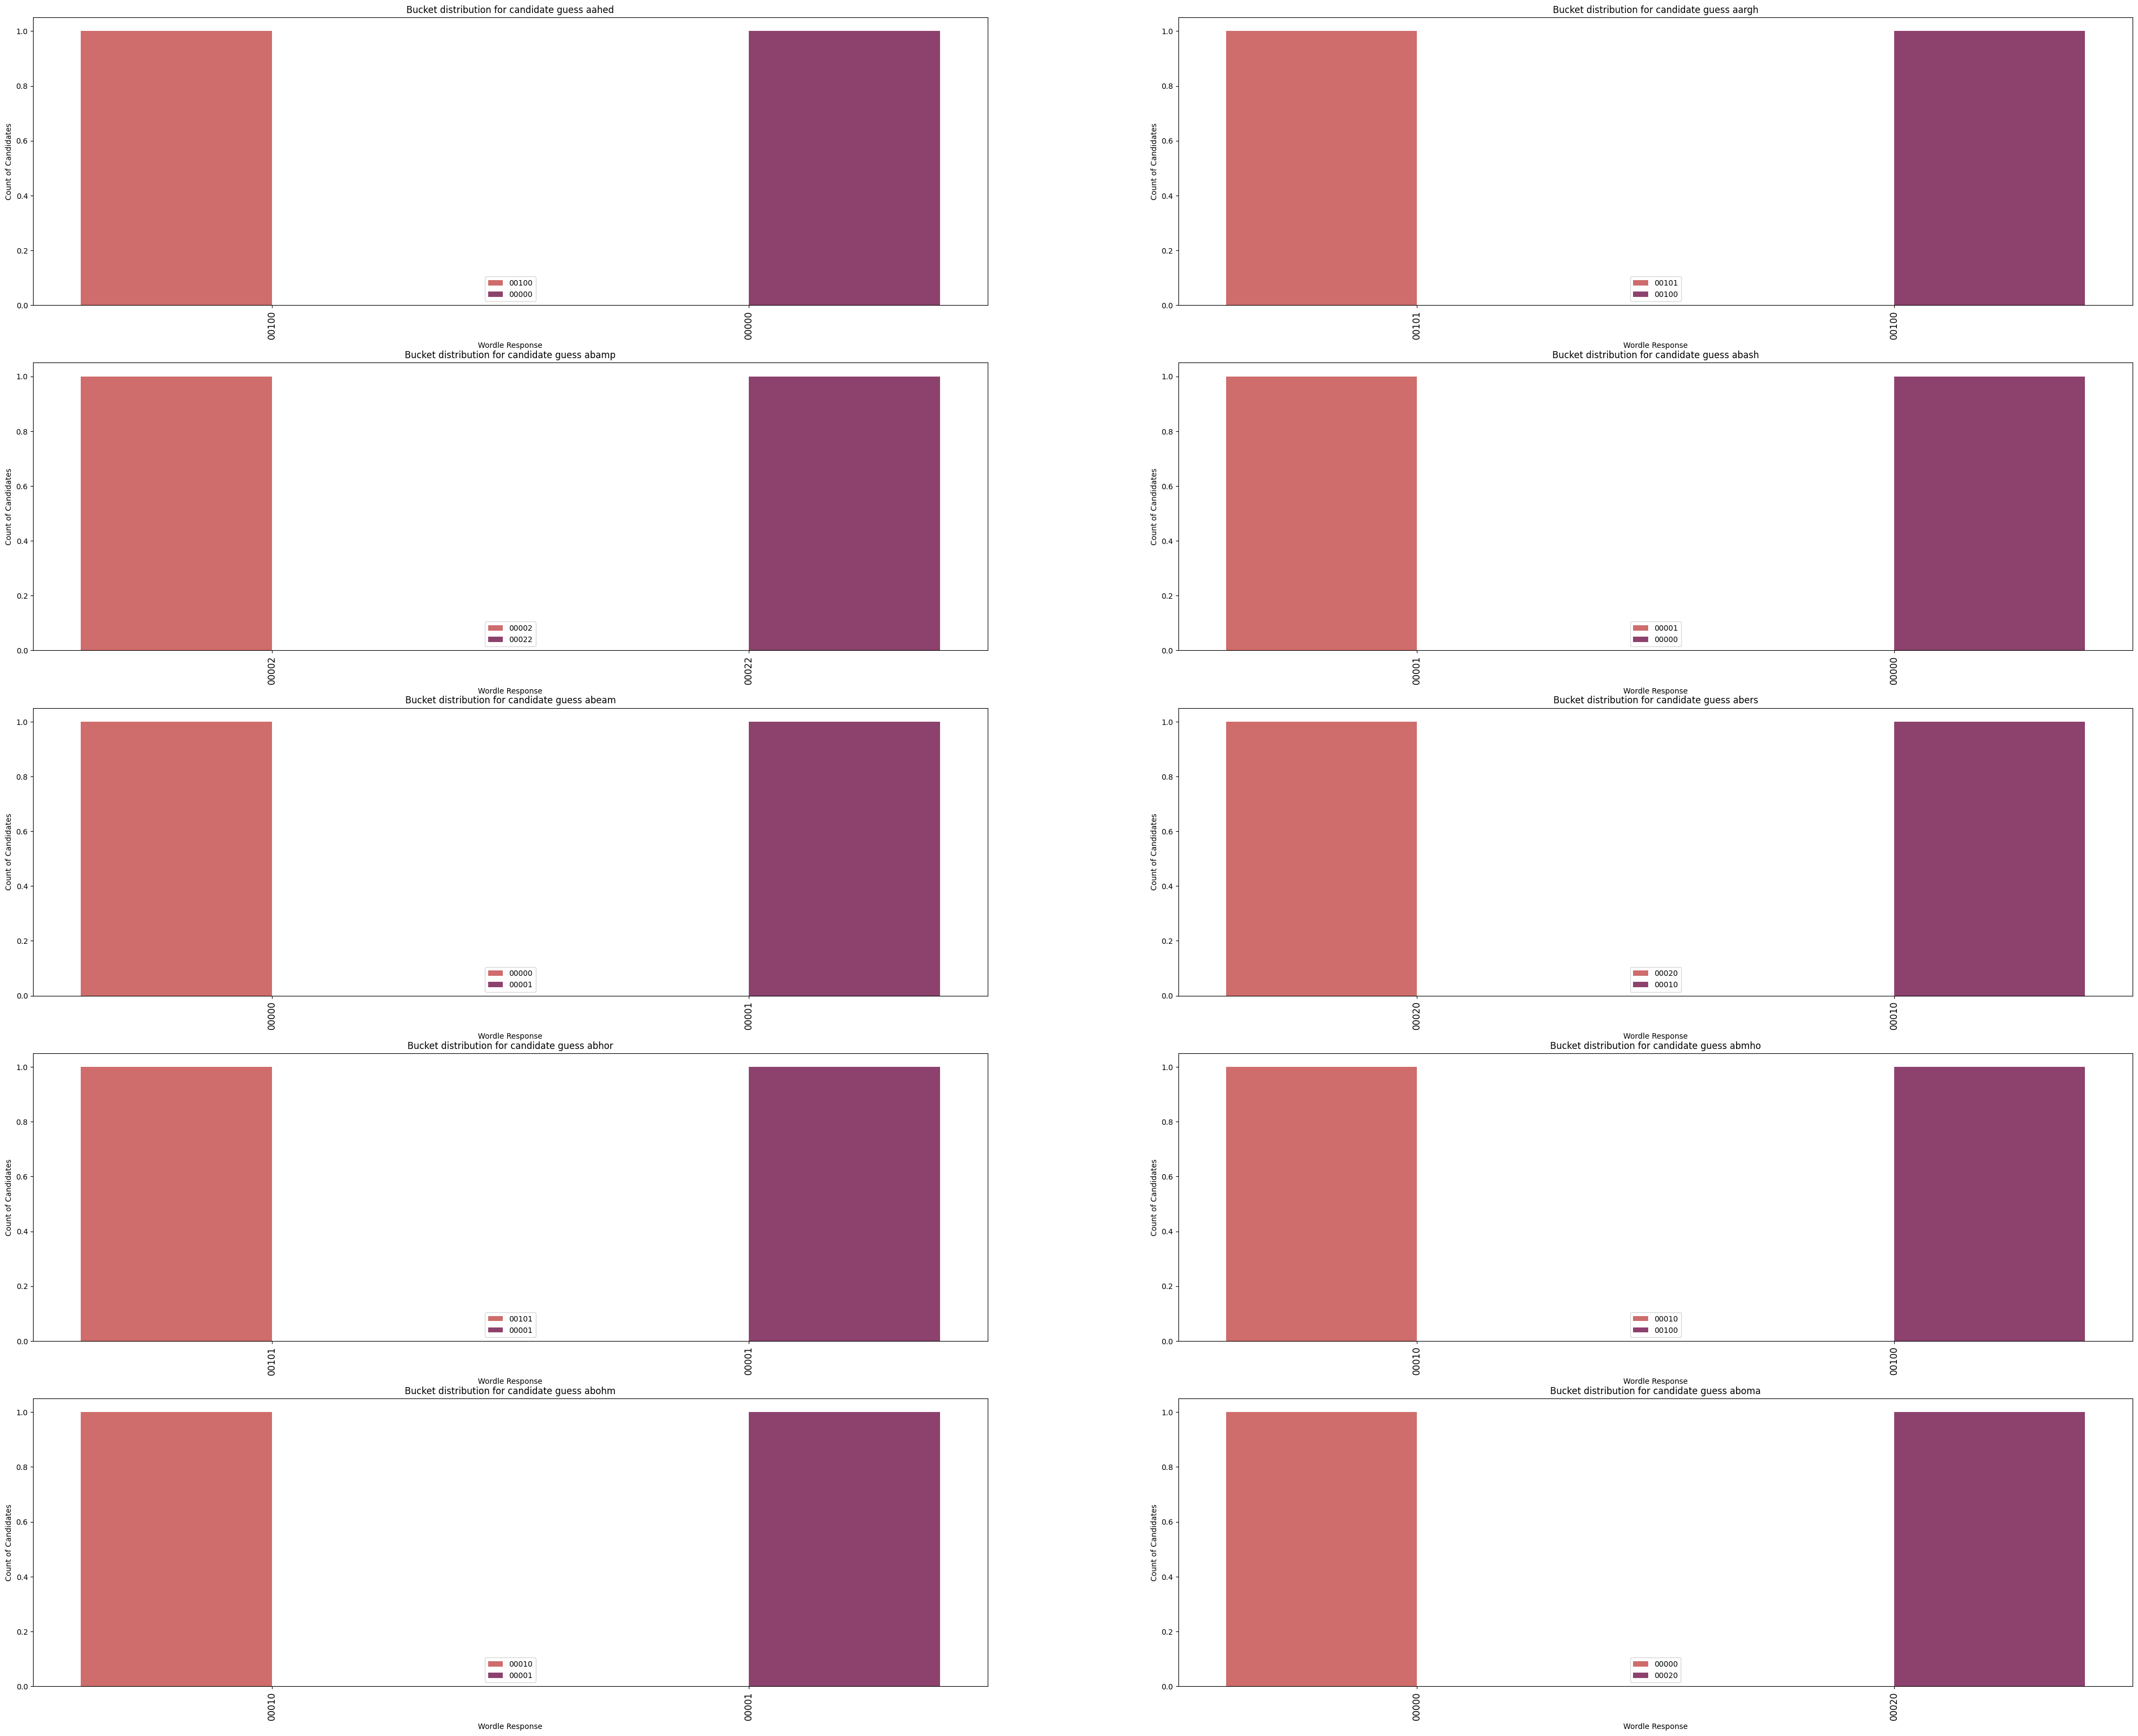

In [43]:
plot_bucket_distributions(l3_best_candidates, l3_response_bucket_distribution)

In [47]:
l3_response_buckets = make_response_buckets('chirp', valid_solutions, l2_response_buckets)

In [48]:
l3_response_buckets

{'00211':     word
 0  primo
 1  prior
 2  privy}

In [50]:
valid_solutions = l3_response_buckets['00211']
print(valid_solutions)
l4_response_bucket_distribution = wordle_response_bucket_distributions(valid_solutions)

    word
0  primo
1  prior
2  privy


In [51]:
l4_response_bucket_distribution = wordle_response_bucket_distributions(valid_solutions)
l4_sl_bucket_sizes, l4_best_candidates = find_n_smallest_largest_buckets(10, l4_response_bucket_distribution)

In [ ]:
# Total flow:
# Using the base best candidate 'raise', characterized by a tied smallest largest bucket and the smallest second largest bucket, as our root
# Wait for a response from the user, and enter the response bucket corresponding to the wordle_feedback
# With a restricted set of valid solutions, determine a new best candidate and repeat.

# Note: when len(valid_solutions) == 1: it immediately becomes the best candidate. when 1 is the length of the largest bucket, if there exists a bucket with 22222, add it to the best candidates, then return one
